In [22]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score, auc

import utils
import models.net as net
import models.data_loader as data_loader

import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configure Project


In [2]:
# Directory containing the .txt metadata about dataset
data_dir = 'data/4326'
layer_name = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'
label_split = os.path.join(data_dir, layer_name + ".txt")

# Directory containing params.json
model_dir = 'experiments/base_model'

# Name of the file in --model_dir containing weights to reload before training
restore_file = 'best' # 'best' or 'train' or None

### Training Function Definitions

In [3]:
def evaluate(model, loss_fn, dataloader, metrics, params):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []
    
    X = None
    outputs_prob = None
    outputs_pred = None
    labels = None

    # compute metrics over the dataset
    with tqdm_notebook(total=len(dataloader)) as t:
        for data_batch, labels_batch in dataloader:
            # move to GPU if available
            if params.cuda:
                data_batch, labels_batch = data_batch.cuda(async=True), labels_batch.cuda(async=True)
            # fetch the next evaluation batch
            data_batch, labels_batch = Variable(data_batch), Variable(labels_batch)

            # compute model output
            output_batch = model(data_batch)
            loss = loss_fn(output_batch, labels_batch)

            # extract data from torch Variable, move to cpu, convert to numpy arrays
            output_batch = output_batch.data.cpu().numpy()
            output_pred_batch = np.argmax(output_batch, axis=1)
            labels_batch = labels_batch.data.cpu().numpy()

            # save the outputs and labels
            if X is None:
                X = data_batch
                outputs_prob = output_batch
                outputs_pred = output_pred_batch
                labels = labels_batch
            else:
                X = np.append(X, data_batch, axis=0)
                outputs_prob = np.append(outputs_prob, output_batch, axis=0)
                outputs_pred = np.append(outputs_pred, output_pred_batch, axis=0)
                labels = np.append(labels, labels_batch, axis=0)

            # compute all metrics on this batch
            summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                             for metric in metrics}
            summary_batch['loss'] = loss.data[0]
            summ.append(summary_batch)

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Eval metrics : " + metrics_string)
    
    return X, outputs_prob, outputs_pred, labels, metrics_mean

def train(model, optimizer, loss_fn, dataloader, metrics, params):
    """Train the model on `num_steps` batches
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = utils.RunningAverage()

    # Use tqdm for progress bar
    with tqdm_notebook(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            loss = loss_fn(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            # Evaluate summaries only once in a while
            if i % params.save_summary_steps == 0:
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data[0]
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data[0])

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)


def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.
    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)

    best_val_score = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics, params)

        # Evaluate for one epoch on validation set
        _, _, _, _, val_metrics = evaluate(model, loss_fn, val_dataloader, metrics, params)

        val_score = val_metrics['AUC']
        is_best = val_score>best_val_score

        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict' : optimizer.state_dict()},
                               is_best=is_best,
                               checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logging.info("- Found new best accuracy")
            print("best_val_score {:05.3f}".format(best_val_score))
            print("val_score {:05.3f}".format(val_score))
            best_val_score = val_score

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        utils.save_dict_to_json(val_metrics, last_json_path)

### Load Hyperparameters from File

In [4]:
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

# use GPU if available
params.cuda = torch.cuda.is_available()
print("GPU available: {}".format(params.cuda))

# Set the random seed for reproducible experiments
torch.manual_seed(230)
if params.cuda: torch.cuda.manual_seed(230)

GPU available: False


### Define the Model, Loss, and Optimizer

In [5]:
# Define the model and optimizer
model = net.Net(params, num_classes=2).cuda() if params.cuda else net.Net(params, num_classes=2)

# Define the loss
loss_fn = net.loss_fn

# Optimize only the classifier
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

### Define Metrics

In [6]:
# Fetch metrics
def accuracy(outputs, labels):
    """
    Compute the accuracy, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) accuracy in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

def recall(outputs, labels):
    """
    Compute the recall, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) recall in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return recall_score(labels, outputs)

def precision(outputs, labels):
    """
    Compute the precision, given the outputs and labels for all images. 
    
    The precision is the ratio tp / (tp + fp) where tp is the number 
    of true positives and fp the number of false positives. 
    
    The precision is intuitively the ability of the classifier not to 
    label as positive a sample that is negative.
    
    The best value is 1 and the worst value is 0.
    
    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) precision in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return precision_score(labels, outputs)

def f1_metric(outputs, labels):
    """
    Compute the F1 score, given the outputs and labels for all images.

    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]

    Returns: (float) F1 score in [0,1]
    """
    outputs = np.argmax(outputs, axis=1)
    return f1_score(labels, outputs)

def roc_graph(outputs, labels):
    """
    Compute Receiver operating characteristic (ROC).
    
    Args:
        outputs: (np.ndarray) dimension batch_size x 2 - log softmax output of the model
        labels: (np.ndarray) dimension batch_size, where each element is a value in [0, 1]
        
    Returns: fpr, tpr, thresholds
    """
    outputs = outputs[:,1]
    return roc_curve(labels, outputs)

def roc_auc_metric(outputs, labels):
    """
    Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    """
    outputs = outputs[:,1]
    return roc_auc_score(labels, outputs)

# maintain all metrics required in this dictionary- these are used in the training and evaluation loops
metrics = {
    'AUC': roc_auc_metric, # area under receiver operator characteristic curve
    'F1': f1_metric, # weighted average of precision and recall
    'recall': recall, 
    'precision': precision,
    'accuracy': accuracy,
    # could add more metrics such as accuracy for each token type
}

# Run Experiment

### Load the Datasets

In [7]:
# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Create the input data pipeline
logging.info("Loading the datasets...")

# Set the model input size
IMG_DIM = (128, 256)
IMG_PADDING = (0, 64, 0, 64) # left, top, right, bottom borders

# borrowed from http://pytorch.org/tutorials/advanced/neural_style_tutorial.html
# and http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# define a training image loader that specifies transforms on images. See documentation for more details.
train_transformer = transforms.Compose([
    transforms.Resize(IMG_DIM),  # resize the image 
    transforms.Pad(padding=IMG_PADDING, fill=0), # pad to be square!
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.RandomVerticalFlip(), # randomly flip image vertically
    transforms.ToTensor(), # transform it into a torch tensor
    lambda x: x>0,
    lambda x: x.float(),
    ])  

# loader for evaluation, no data augmentation (e.g. horizontal flip)
eval_transformer = transforms.Compose([
    transforms.Resize(IMG_DIM),  # resize the image
    transforms.Pad(padding=IMG_PADDING, fill=0), # pad to be square!
    transforms.Grayscale(),
    transforms.ToTensor(), # transform it into a torch tensor
    lambda x: x>0,
    lambda x: x.float(),
    ])  

# fetch dataloaders
train_dl = data_loader.fetch_dataloader('train', train_transformer, data_dir, layer_name, label_split, params)
val_dl = data_loader.fetch_dataloader('val', eval_transformer, data_dir, layer_name, label_split, params)
test_dl = data_loader.fetch_dataloader('test', eval_transformer, data_dir, layer_name, label_split, params)

logging.info("- done.")

Loading the datasets...
- done.


### Train the Model

In [8]:
# Train the model
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
train_and_evaluate(model, train_dl, val_dl, optimizer, loss_fn, metrics, params, model_dir, restore_file)

Starting training for 100 epoch(s)
Restoring parameters from experiments/base_model/best.pth.tar
Epoch 1/100


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Train metrics: AUC: 0.794 ; F1: 0.400 ; recall: 0.684 ; precision: 0.283 ; accuracy: 0.695 ; loss: 0.615


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Eval metrics : AUC: 0.876 ; F1: 0.256 ; recall: 0.906 ; precision: 0.154 ; accuracy: 0.645 ; loss: 0.664


- Found new best accuracy
Epoch 2/100


best_val_score 0.000
val_score 0.876


- Train metrics: AUC: 0.847 ; F1: 0.426 ; recall: 0.812 ; precision: 0.289 ; accuracy: 0.727 ; loss: 0.578


- Eval metrics : AUC: 0.874 ; F1: 0.317 ; recall: 0.844 ; precision: 0.202 ; accuracy: 0.761 ; loss: 0.618


Epoch 3/100


- Train metrics: AUC: 0.745 ; F1: 0.367 ; recall: 0.647 ; precision: 0.256 ; accuracy: 0.703 ; loss: 0.600


- Eval metrics : AUC: 0.877 ; F1: 0.336 ; recall: 0.844 ; precision: 0.217 ; accuracy: 0.781 ; loss: 0.600


- Found new best accuracy
Epoch 4/100


best_val_score 0.876
val_score 0.877


- Train metrics: AUC: 0.747 ; F1: 0.317 ; recall: 0.625 ; precision: 0.213 ; accuracy: 0.664 ; loss: 0.635


- Eval metrics : AUC: 0.875 ; F1: 0.352 ; recall: 0.812 ; precision: 0.232 ; accuracy: 0.802 ; loss: 0.581


Epoch 5/100


- Train metrics: AUC: 0.865 ; F1: 0.388 ; recall: 0.867 ; precision: 0.250 ; accuracy: 0.680 ; loss: 0.621


- Eval metrics : AUC: 0.884 ; F1: 0.412 ; recall: 0.844 ; precision: 0.278 ; accuracy: 0.834 ; loss: 0.575


- Found new best accuracy
Epoch 6/100


best_val_score 0.877
val_score 0.884


- Train metrics: AUC: 0.929 ; F1: 0.549 ; recall: 0.933 ; precision: 0.389 ; accuracy: 0.820 ; loss: 0.563


- Eval metrics : AUC: 0.886 ; F1: 0.416 ; recall: 0.844 ; precision: 0.282 ; accuracy: 0.838 ; loss: 0.575


- Found new best accuracy
Epoch 7/100


best_val_score 0.884
val_score 0.886


- Train metrics: AUC: 0.805 ; F1: 0.213 ; recall: 0.625 ; precision: 0.128 ; accuracy: 0.711 ; loss: 0.600


- Eval metrics : AUC: 0.891 ; F1: 0.416 ; recall: 0.844 ; precision: 0.282 ; accuracy: 0.838 ; loss: 0.573


- Found new best accuracy
Epoch 8/100


best_val_score 0.886
val_score 0.891


- Train metrics: AUC: 0.864 ; F1: 0.327 ; recall: 0.750 ; precision: 0.209 ; accuracy: 0.711 ; loss: 0.599


- Eval metrics : AUC: 0.892 ; F1: 0.408 ; recall: 0.812 ; precision: 0.281 ; accuracy: 0.841 ; loss: 0.569


- Found new best accuracy
Epoch 9/100


best_val_score 0.891
val_score 0.892


- Train metrics: AUC: 0.789 ; F1: 0.520 ; recall: 0.722 ; precision: 0.406 ; accuracy: 0.812 ; loss: 0.561


- Eval metrics : AUC: 0.893 ; F1: 0.396 ; recall: 0.781 ; precision: 0.275 ; accuracy: 0.841 ; loss: 0.564


- Found new best accuracy
Epoch 10/100


best_val_score 0.892
val_score 0.893


- Train metrics: AUC: 0.794 ; F1: 0.295 ; recall: 0.643 ; precision: 0.191 ; accuracy: 0.664 ; loss: 0.610


- Eval metrics : AUC: 0.894 ; F1: 0.408 ; recall: 0.812 ; precision: 0.281 ; accuracy: 0.841 ; loss: 0.566


- Found new best accuracy
Epoch 11/100


best_val_score 0.893
val_score 0.894


- Train metrics: AUC: 0.724 ; F1: 0.300 ; recall: 0.562 ; precision: 0.205 ; accuracy: 0.672 ; loss: 0.627


- Eval metrics : AUC: 0.896 ; F1: 0.408 ; recall: 0.812 ; precision: 0.281 ; accuracy: 0.841 ; loss: 0.565


- Found new best accuracy
Epoch 12/100


best_val_score 0.894
val_score 0.896


- Train metrics: AUC: 0.889 ; F1: 0.557 ; recall: 0.773 ; precision: 0.436 ; accuracy: 0.789 ; loss: 0.571


- Eval metrics : AUC: 0.896 ; F1: 0.408 ; recall: 0.812 ; precision: 0.281 ; accuracy: 0.841 ; loss: 0.564


- Found new best accuracy
Epoch 13/100


best_val_score 0.896
val_score 0.896


- Train metrics: AUC: 0.828 ; F1: 0.441 ; recall: 0.684 ; precision: 0.325 ; accuracy: 0.742 ; loss: 0.560


- Eval metrics : AUC: 0.899 ; F1: 0.405 ; recall: 0.781 ; precision: 0.286 ; accuracy: 0.849 ; loss: 0.557


- Found new best accuracy
Epoch 14/100


best_val_score 0.896
val_score 0.899


- Train metrics: AUC: 0.856 ; F1: 0.576 ; recall: 0.680 ; precision: 0.500 ; accuracy: 0.805 ; loss: 0.556


- Eval metrics : AUC: 0.901 ; F1: 0.417 ; recall: 0.812 ; precision: 0.292 ; accuracy: 0.849 ; loss: 0.559


- Found new best accuracy
Epoch 15/100


best_val_score 0.899
val_score 0.901


- Train metrics: AUC: 0.894 ; F1: 0.441 ; recall: 0.882 ; precision: 0.294 ; accuracy: 0.703 ; loss: 0.593


- Eval metrics : AUC: 0.904 ; F1: 0.422 ; recall: 0.812 ; precision: 0.297 ; accuracy: 0.853 ; loss: 0.559


- Found new best accuracy
Epoch 16/100


best_val_score 0.901
val_score 0.904


- Train metrics: AUC: 0.821 ; F1: 0.576 ; recall: 0.810 ; precision: 0.447 ; accuracy: 0.805 ; loss: 0.567


- Eval metrics : AUC: 0.902 ; F1: 0.417 ; recall: 0.812 ; precision: 0.292 ; accuracy: 0.849 ; loss: 0.558


Epoch 17/100


- Train metrics: AUC: 0.913 ; F1: 0.456 ; recall: 0.867 ; precision: 0.310 ; accuracy: 0.758 ; loss: 0.568


- Eval metrics : AUC: 0.901 ; F1: 0.422 ; recall: 0.812 ; precision: 0.297 ; accuracy: 0.853 ; loss: 0.557


Epoch 18/100


- Train metrics: AUC: 0.773 ; F1: 0.333 ; recall: 0.733 ; precision: 0.216 ; accuracy: 0.656 ; loss: 0.629


- Eval metrics : AUC: 0.902 ; F1: 0.433 ; recall: 0.812 ; precision: 0.310 ; accuracy: 0.861 ; loss: 0.555


Epoch 19/100


- Train metrics: AUC: 0.792 ; F1: 0.367 ; recall: 0.688 ; precision: 0.250 ; accuracy: 0.703 ; loss: 0.603


- Eval metrics : AUC: 0.904 ; F1: 0.433 ; recall: 0.812 ; precision: 0.310 ; accuracy: 0.861 ; loss: 0.555


Epoch 20/100


- Train metrics: AUC: 0.975 ; F1: 0.612 ; recall: 0.938 ; precision: 0.455 ; accuracy: 0.852 ; loss: 0.532


- Eval metrics : AUC: 0.907 ; F1: 0.433 ; recall: 0.812 ; precision: 0.310 ; accuracy: 0.861 ; loss: 0.555


- Found new best accuracy
Epoch 21/100


best_val_score 0.904
val_score 0.907


- Train metrics: AUC: 0.788 ; F1: 0.444 ; recall: 0.632 ; precision: 0.343 ; accuracy: 0.766 ; loss: 0.575


- Eval metrics : AUC: 0.904 ; F1: 0.444 ; recall: 0.812 ; precision: 0.325 ; accuracy: 0.869 ; loss: 0.552


Epoch 22/100


- Train metrics: AUC: 0.720 ; F1: 0.207 ; recall: 0.667 ; precision: 0.122 ; accuracy: 0.641 ; loss: 0.643


- Eval metrics : AUC: 0.905 ; F1: 0.450 ; recall: 0.812 ; precision: 0.333 ; accuracy: 0.873 ; loss: 0.550


Epoch 23/100


- Train metrics: AUC: 0.881 ; F1: 0.492 ; recall: 0.833 ; precision: 0.349 ; accuracy: 0.758 ; loss: 0.581


- Eval metrics : AUC: 0.909 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.549


- Found new best accuracy
Epoch 24/100


best_val_score 0.907
val_score 0.909


- Train metrics: AUC: 0.832 ; F1: 0.423 ; recall: 0.579 ; precision: 0.333 ; accuracy: 0.766 ; loss: 0.551


- Eval metrics : AUC: 0.910 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.547


- Found new best accuracy
Epoch 25/100


best_val_score 0.909
val_score 0.910


- Train metrics: AUC: 0.795 ; F1: 0.489 ; recall: 0.611 ; precision: 0.407 ; accuracy: 0.820 ; loss: 0.556


- Eval metrics : AUC: 0.910 ; F1: 0.500 ; recall: 0.812 ; precision: 0.375 ; accuracy: 0.889 ; loss: 0.545


- Found new best accuracy
Epoch 26/100


best_val_score 0.910
val_score 0.910


- Train metrics: AUC: 0.731 ; F1: 0.377 ; recall: 0.667 ; precision: 0.263 ; accuracy: 0.742 ; loss: 0.609


- Eval metrics : AUC: 0.913 ; F1: 0.460 ; recall: 0.812 ; precision: 0.335 ; accuracy: 0.873 ; loss: 0.550


- Found new best accuracy
Epoch 27/100


best_val_score 0.910
val_score 0.913


- Train metrics: AUC: 0.779 ; F1: 0.350 ; recall: 0.583 ; precision: 0.250 ; accuracy: 0.797 ; loss: 0.589


- Eval metrics : AUC: 0.915 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.549


- Found new best accuracy
Epoch 28/100


best_val_score 0.913
val_score 0.915


- Train metrics: AUC: 0.794 ; F1: 0.355 ; recall: 0.786 ; precision: 0.229 ; accuracy: 0.688 ; loss: 0.620


- Eval metrics : AUC: 0.913 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.548


Epoch 29/100


- Train metrics: AUC: 0.936 ; F1: 0.481 ; recall: 0.867 ; precision: 0.333 ; accuracy: 0.781 ; loss: 0.551


- Eval metrics : AUC: 0.911 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.544


Epoch 30/100


- Train metrics: AUC: 0.889 ; F1: 0.632 ; recall: 0.750 ; precision: 0.545 ; accuracy: 0.836 ; loss: 0.516


- Eval metrics : AUC: 0.919 ; F1: 0.479 ; recall: 0.812 ; precision: 0.360 ; accuracy: 0.885 ; loss: 0.540


- Found new best accuracy
Epoch 31/100


best_val_score 0.915
val_score 0.919


- Train metrics: AUC: 0.843 ; F1: 0.481 ; recall: 0.650 ; precision: 0.382 ; accuracy: 0.781 ; loss: 0.564


- Eval metrics : AUC: 0.922 ; F1: 0.506 ; recall: 0.812 ; precision: 0.384 ; accuracy: 0.893 ; loss: 0.539


- Found new best accuracy
Epoch 32/100


best_val_score 0.919
val_score 0.922


- Train metrics: AUC: 0.856 ; F1: 0.531 ; recall: 0.765 ; precision: 0.406 ; accuracy: 0.820 ; loss: 0.541


- Eval metrics : AUC: 0.924 ; F1: 0.506 ; recall: 0.812 ; precision: 0.384 ; accuracy: 0.893 ; loss: 0.543


- Found new best accuracy
Epoch 33/100


best_val_score 0.922
val_score 0.924


- Train metrics: AUC: 0.818 ; F1: 0.400 ; recall: 0.688 ; precision: 0.282 ; accuracy: 0.742 ; loss: 0.578


- Eval metrics : AUC: 0.924 ; F1: 0.472 ; recall: 0.812 ; precision: 0.351 ; accuracy: 0.881 ; loss: 0.544


Epoch 34/100


- Train metrics: AUC: 0.865 ; F1: 0.471 ; recall: 0.889 ; precision: 0.320 ; accuracy: 0.719 ; loss: 0.593


- Eval metrics : AUC: 0.926 ; F1: 0.549 ; recall: 0.812 ; precision: 0.427 ; accuracy: 0.905 ; loss: 0.541


- Found new best accuracy
Epoch 35/100


best_val_score 0.924
val_score 0.926


- Train metrics: AUC: 0.751 ; F1: 0.361 ; recall: 0.611 ; precision: 0.256 ; accuracy: 0.695 ; loss: 0.607


- Eval metrics : AUC: 0.925 ; F1: 0.549 ; recall: 0.812 ; precision: 0.427 ; accuracy: 0.905 ; loss: 0.540


Epoch 36/100


- Train metrics: AUC: 0.850 ; F1: 0.549 ; recall: 0.700 ; precision: 0.452 ; accuracy: 0.820 ; loss: 0.531


- Eval metrics : AUC: 0.925 ; F1: 0.556 ; recall: 0.812 ; precision: 0.438 ; accuracy: 0.909 ; loss: 0.534


Epoch 37/100


- Train metrics: AUC: 0.854 ; F1: 0.444 ; recall: 0.714 ; precision: 0.323 ; accuracy: 0.805 ; loss: 0.552


- Eval metrics : AUC: 0.926 ; F1: 0.549 ; recall: 0.812 ; precision: 0.427 ; accuracy: 0.905 ; loss: 0.537


Epoch 38/100


- Train metrics: AUC: 0.843 ; F1: 0.524 ; recall: 0.647 ; precision: 0.440 ; accuracy: 0.844 ; loss: 0.531


- Eval metrics : AUC: 0.926 ; F1: 0.556 ; recall: 0.812 ; precision: 0.438 ; accuracy: 0.909 ; loss: 0.537


- Found new best accuracy
Epoch 39/100


best_val_score 0.926
val_score 0.926


- Train metrics: AUC: 0.889 ; F1: 0.596 ; recall: 0.850 ; precision: 0.459 ; accuracy: 0.820 ; loss: 0.543


- Eval metrics : AUC: 0.926 ; F1: 0.631 ; recall: 0.844 ; precision: 0.512 ; accuracy: 0.925 ; loss: 0.535


- Found new best accuracy
Epoch 40/100


best_val_score 0.926
val_score 0.926


- Train metrics: AUC: 0.909 ; F1: 0.488 ; recall: 0.833 ; precision: 0.345 ; accuracy: 0.836 ; loss: 0.547


- Eval metrics : AUC: 0.926 ; F1: 0.611 ; recall: 0.812 ; precision: 0.500 ; accuracy: 0.921 ; loss: 0.531


Epoch 41/100


- Train metrics: AUC: 0.819 ; F1: 0.353 ; recall: 0.750 ; precision: 0.231 ; accuracy: 0.742 ; loss: 0.587


- Eval metrics : AUC: 0.927 ; F1: 0.639 ; recall: 0.844 ; precision: 0.525 ; accuracy: 0.929 ; loss: 0.533


- Found new best accuracy
Epoch 42/100


best_val_score 0.926
val_score 0.927


- Train metrics: AUC: 0.965 ; F1: 0.571 ; recall: 0.923 ; precision: 0.414 ; accuracy: 0.859 ; loss: 0.523


- Eval metrics : AUC: 0.927 ; F1: 0.639 ; recall: 0.844 ; precision: 0.525 ; accuracy: 0.929 ; loss: 0.534


Epoch 43/100


- Train metrics: AUC: 0.816 ; F1: 0.441 ; recall: 0.765 ; precision: 0.310 ; accuracy: 0.742 ; loss: 0.574


- Eval metrics : AUC: 0.927 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.531


Epoch 44/100


- Train metrics: AUC: 0.923 ; F1: 0.582 ; recall: 0.889 ; precision: 0.432 ; accuracy: 0.820 ; loss: 0.550


- Eval metrics : AUC: 0.927 ; F1: 0.619 ; recall: 0.812 ; precision: 0.513 ; accuracy: 0.925 ; loss: 0.530


- Found new best accuracy
Epoch 45/100


best_val_score 0.927
val_score 0.927


- Train metrics: AUC: 0.875 ; F1: 0.612 ; recall: 0.789 ; precision: 0.500 ; accuracy: 0.852 ; loss: 0.528


- Eval metrics : AUC: 0.927 ; F1: 0.606 ; recall: 0.781 ; precision: 0.515 ; accuracy: 0.925 ; loss: 0.526


Epoch 46/100


- Train metrics: AUC: 0.908 ; F1: 0.591 ; recall: 0.722 ; precision: 0.500 ; accuracy: 0.859 ; loss: 0.519


- Eval metrics : AUC: 0.926 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.533


Epoch 47/100


- Train metrics: AUC: 0.821 ; F1: 0.372 ; recall: 0.727 ; precision: 0.250 ; accuracy: 0.789 ; loss: 0.589


- Eval metrics : AUC: 0.928 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.532


- Found new best accuracy
Epoch 48/100


best_val_score 0.927
val_score 0.928


- Train metrics: AUC: 0.879 ; F1: 0.545 ; recall: 0.706 ; precision: 0.444 ; accuracy: 0.844 ; loss: 0.521


- Eval metrics : AUC: 0.927 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.530


Epoch 49/100


- Train metrics: AUC: 0.921 ; F1: 0.565 ; recall: 0.867 ; precision: 0.419 ; accuracy: 0.844 ; loss: 0.544


- Eval metrics : AUC: 0.929 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.530


- Found new best accuracy
Epoch 50/100


best_val_score 0.928
val_score 0.929


- Train metrics: AUC: 0.891 ; F1: 0.508 ; recall: 0.842 ; precision: 0.364 ; accuracy: 0.758 ; loss: 0.559


- Eval metrics : AUC: 0.930 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.530


- Found new best accuracy
Epoch 51/100


best_val_score 0.929
val_score 0.930


- Train metrics: AUC: 0.892 ; F1: 0.533 ; recall: 0.706 ; precision: 0.429 ; accuracy: 0.836 ; loss: 0.525


- Eval metrics : AUC: 0.929 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.528


Epoch 52/100


- Train metrics: AUC: 0.834 ; F1: 0.462 ; recall: 0.692 ; precision: 0.346 ; accuracy: 0.836 ; loss: 0.545


- Eval metrics : AUC: 0.931 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.528


- Found new best accuracy
Epoch 53/100


best_val_score 0.930
val_score 0.931


- Train metrics: AUC: 0.855 ; F1: 0.450 ; recall: 0.643 ; precision: 0.346 ; accuracy: 0.828 ; loss: 0.542


- Eval metrics : AUC: 0.930 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.528


Epoch 54/100


- Train metrics: AUC: 0.835 ; F1: 0.533 ; recall: 0.571 ; precision: 0.500 ; accuracy: 0.891 ; loss: 0.512


- Eval metrics : AUC: 0.930 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.524


Epoch 55/100


- Train metrics: AUC: 0.890 ; F1: 0.490 ; recall: 0.857 ; precision: 0.343 ; accuracy: 0.805 ; loss: 0.559


- Eval metrics : AUC: 0.932 ; F1: 0.636 ; recall: 0.812 ; precision: 0.544 ; accuracy: 0.933 ; loss: 0.516


- Found new best accuracy
Epoch 56/100


best_val_score 0.931
val_score 0.932


- Train metrics: AUC: 0.883 ; F1: 0.545 ; recall: 0.706 ; precision: 0.444 ; accuracy: 0.844 ; loss: 0.524


- Eval metrics : AUC: 0.930 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.519


Epoch 57/100


- Train metrics: AUC: 0.876 ; F1: 0.511 ; recall: 0.750 ; precision: 0.387 ; accuracy: 0.820 ; loss: 0.560


- Eval metrics : AUC: 0.932 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.518


Epoch 58/100


- Train metrics: AUC: 0.856 ; F1: 0.531 ; recall: 0.765 ; precision: 0.406 ; accuracy: 0.820 ; loss: 0.533


- Eval metrics : AUC: 0.934 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.522


- Found new best accuracy
Epoch 59/100


best_val_score 0.932
val_score 0.934


- Train metrics: AUC: 0.825 ; F1: 0.435 ; recall: 0.667 ; precision: 0.323 ; accuracy: 0.797 ; loss: 0.543


- Eval metrics : AUC: 0.933 ; F1: 0.627 ; recall: 0.812 ; precision: 0.528 ; accuracy: 0.929 ; loss: 0.518


Epoch 60/100


- Train metrics: AUC: 0.953 ; F1: 0.500 ; recall: 0.818 ; precision: 0.360 ; accuracy: 0.859 ; loss: 0.539


- Eval metrics : AUC: 0.933 ; F1: 0.627 ; recall: 0.812 ; precision: 0.528 ; accuracy: 0.929 ; loss: 0.519


Epoch 61/100


- Train metrics: AUC: 0.882 ; F1: 0.622 ; recall: 0.824 ; precision: 0.500 ; accuracy: 0.867 ; loss: 0.522


- Eval metrics : AUC: 0.934 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.522


- Found new best accuracy
Epoch 62/100


best_val_score 0.934
val_score 0.934


- Train metrics: AUC: 0.930 ; F1: 0.593 ; recall: 0.889 ; precision: 0.444 ; accuracy: 0.828 ; loss: 0.521


- Eval metrics : AUC: 0.934 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.521


Epoch 63/100


- Train metrics: AUC: 0.897 ; F1: 0.435 ; recall: 0.833 ; precision: 0.294 ; accuracy: 0.797 ; loss: 0.567


- Eval metrics : AUC: 0.935 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.521


- Found new best accuracy
Epoch 64/100


best_val_score 0.934
val_score 0.935


- Train metrics: AUC: 0.845 ; F1: 0.509 ; recall: 0.737 ; precision: 0.389 ; accuracy: 0.789 ; loss: 0.541


- Eval metrics : AUC: 0.934 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.519


Epoch 65/100


- Train metrics: AUC: 0.873 ; F1: 0.579 ; recall: 0.647 ; precision: 0.524 ; accuracy: 0.875 ; loss: 0.526


- Eval metrics : AUC: 0.934 ; F1: 0.657 ; recall: 0.844 ; precision: 0.556 ; accuracy: 0.937 ; loss: 0.511


Epoch 66/100


- Train metrics: AUC: 0.768 ; F1: 0.465 ; recall: 0.625 ; precision: 0.370 ; accuracy: 0.820 ; loss: 0.547


- Eval metrics : AUC: 0.936 ; F1: 0.657 ; recall: 0.844 ; precision: 0.556 ; accuracy: 0.937 ; loss: 0.513


- Found new best accuracy
Epoch 67/100


best_val_score 0.935
val_score 0.936


- Train metrics: AUC: 0.831 ; F1: 0.583 ; recall: 0.700 ; precision: 0.500 ; accuracy: 0.844 ; loss: 0.543


- Eval metrics : AUC: 0.936 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.515


Epoch 68/100


- Train metrics: AUC: 0.950 ; F1: 0.694 ; recall: 0.850 ; precision: 0.586 ; accuracy: 0.883 ; loss: 0.501


- Eval metrics : AUC: 0.934 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.517


Epoch 69/100


- Train metrics: AUC: 0.896 ; F1: 0.634 ; recall: 0.722 ; precision: 0.565 ; accuracy: 0.883 ; loss: 0.496


- Eval metrics : AUC: 0.933 ; F1: 0.627 ; recall: 0.812 ; precision: 0.528 ; accuracy: 0.929 ; loss: 0.514


Epoch 70/100


- Train metrics: AUC: 0.822 ; F1: 0.651 ; recall: 0.737 ; precision: 0.583 ; accuracy: 0.883 ; loss: 0.523


- Eval metrics : AUC: 0.934 ; F1: 0.627 ; recall: 0.812 ; precision: 0.528 ; accuracy: 0.929 ; loss: 0.511


Epoch 71/100


- Train metrics: AUC: 0.880 ; F1: 0.500 ; recall: 0.800 ; precision: 0.364 ; accuracy: 0.812 ; loss: 0.546


- Eval metrics : AUC: 0.936 ; F1: 0.636 ; recall: 0.812 ; precision: 0.544 ; accuracy: 0.933 ; loss: 0.508


- Found new best accuracy
Epoch 72/100


best_val_score 0.936
val_score 0.936


- Train metrics: AUC: 0.734 ; F1: 0.346 ; recall: 0.643 ; precision: 0.237 ; accuracy: 0.734 ; loss: 0.577


- Eval metrics : AUC: 0.932 ; F1: 0.636 ; recall: 0.812 ; precision: 0.544 ; accuracy: 0.933 ; loss: 0.510


Epoch 73/100


- Train metrics: AUC: 0.847 ; F1: 0.500 ; recall: 0.733 ; precision: 0.379 ; accuracy: 0.828 ; loss: 0.533


- Eval metrics : AUC: 0.933 ; F1: 0.724 ; recall: 0.844 ; precision: 0.639 ; accuracy: 0.945 ; loss: 0.510


Epoch 74/100


- Train metrics: AUC: 0.828 ; F1: 0.372 ; recall: 0.571 ; precision: 0.276 ; accuracy: 0.789 ; loss: 0.561


- Eval metrics : AUC: 0.934 ; F1: 0.676 ; recall: 0.875 ; precision: 0.566 ; accuracy: 0.941 ; loss: 0.514


Epoch 75/100


- Train metrics: AUC: 0.872 ; F1: 0.649 ; recall: 0.800 ; precision: 0.545 ; accuracy: 0.898 ; loss: 0.503


- Eval metrics : AUC: 0.936 ; F1: 0.753 ; recall: 0.875 ; precision: 0.667 ; accuracy: 0.953 ; loss: 0.511


Epoch 76/100


- Train metrics: AUC: 0.858 ; F1: 0.511 ; recall: 0.706 ; precision: 0.400 ; accuracy: 0.820 ; loss: 0.537


- Eval metrics : AUC: 0.934 ; F1: 0.676 ; recall: 0.875 ; precision: 0.566 ; accuracy: 0.941 ; loss: 0.511


Epoch 77/100


- Train metrics: AUC: 0.911 ; F1: 0.533 ; recall: 0.667 ; precision: 0.444 ; accuracy: 0.891 ; loss: 0.494


- Eval metrics : AUC: 0.936 ; F1: 0.864 ; recall: 0.875 ; precision: 0.853 ; accuracy: 0.965 ; loss: 0.511


Epoch 78/100


- Train metrics: AUC: 0.903 ; F1: 0.519 ; recall: 0.875 ; precision: 0.368 ; accuracy: 0.797 ; loss: 0.552


- Eval metrics : AUC: 0.936 ; F1: 0.845 ; recall: 0.812 ; precision: 0.885 ; accuracy: 0.965 ; loss: 0.503


- Found new best accuracy
Epoch 79/100


best_val_score 0.936
val_score 0.936


- Train metrics: AUC: 0.898 ; F1: 0.615 ; recall: 0.750 ; precision: 0.522 ; accuracy: 0.883 ; loss: 0.498


- Eval metrics : AUC: 0.936 ; F1: 0.855 ; recall: 0.844 ; precision: 0.867 ; accuracy: 0.965 ; loss: 0.505


Epoch 80/100


- Train metrics: AUC: 0.918 ; F1: 0.744 ; recall: 0.842 ; precision: 0.667 ; accuracy: 0.914 ; loss: 0.503


- Eval metrics : AUC: 0.936 ; F1: 0.855 ; recall: 0.844 ; precision: 0.867 ; accuracy: 0.965 ; loss: 0.508


Epoch 81/100


- Train metrics: AUC: 0.908 ; F1: 0.541 ; recall: 0.833 ; precision: 0.400 ; accuracy: 0.867 ; loss: 0.517


- Eval metrics : AUC: 0.936 ; F1: 0.667 ; recall: 0.844 ; precision: 0.574 ; accuracy: 0.941 ; loss: 0.508


Epoch 82/100


- Train metrics: AUC: 0.895 ; F1: 0.538 ; recall: 0.778 ; precision: 0.412 ; accuracy: 0.812 ; loss: 0.549


- Eval metrics : AUC: 0.938 ; F1: 0.887 ; recall: 0.875 ; precision: 0.900 ; accuracy: 0.973 ; loss: 0.503


- Found new best accuracy
Epoch 83/100


best_val_score 0.936
val_score 0.938


- Train metrics: AUC: 0.874 ; F1: 0.553 ; recall: 0.722 ; precision: 0.448 ; accuracy: 0.836 ; loss: 0.544


- Eval metrics : AUC: 0.936 ; F1: 0.656 ; recall: 0.812 ; precision: 0.583 ; accuracy: 0.941 ; loss: 0.503


Epoch 84/100


- Train metrics: AUC: 0.914 ; F1: 0.667 ; recall: 0.765 ; precision: 0.591 ; accuracy: 0.898 ; loss: 0.507


- Eval metrics : AUC: 0.937 ; F1: 0.636 ; recall: 0.812 ; precision: 0.544 ; accuracy: 0.933 ; loss: 0.504


Epoch 85/100


- Train metrics: AUC: 0.890 ; F1: 0.611 ; recall: 0.647 ; precision: 0.579 ; accuracy: 0.891 ; loss: 0.490


- Eval metrics : AUC: 0.937 ; F1: 0.636 ; recall: 0.812 ; precision: 0.544 ; accuracy: 0.933 ; loss: 0.504


Epoch 86/100


- Train metrics: AUC: 0.962 ; F1: 0.667 ; recall: 0.929 ; precision: 0.520 ; accuracy: 0.898 ; loss: 0.515


- Eval metrics : AUC: 0.938 ; F1: 0.657 ; recall: 0.844 ; precision: 0.556 ; accuracy: 0.937 ; loss: 0.505


Epoch 87/100


- Train metrics: AUC: 0.875 ; F1: 0.533 ; recall: 0.632 ; precision: 0.462 ; accuracy: 0.836 ; loss: 0.505


- Eval metrics : AUC: 0.938 ; F1: 0.648 ; recall: 0.844 ; precision: 0.539 ; accuracy: 0.933 ; loss: 0.507


Epoch 88/100


- Train metrics: AUC: 0.909 ; F1: 0.769 ; recall: 0.833 ; precision: 0.714 ; accuracy: 0.930 ; loss: 0.463


- Eval metrics : AUC: 0.937 ; F1: 0.833 ; recall: 0.812 ; precision: 0.857 ; accuracy: 0.961 ; loss: 0.496


Epoch 89/100


- Train metrics: AUC: 0.892 ; F1: 0.500 ; recall: 0.800 ; precision: 0.364 ; accuracy: 0.875 ; loss: 0.531


- Eval metrics : AUC: 0.938 ; F1: 0.823 ; recall: 0.812 ; precision: 0.833 ; accuracy: 0.957 ; loss: 0.495


Epoch 90/100


- Train metrics: AUC: 0.833 ; F1: 0.541 ; recall: 0.588 ; precision: 0.500 ; accuracy: 0.867 ; loss: 0.512


- Eval metrics : AUC: 0.937 ; F1: 0.833 ; recall: 0.812 ; precision: 0.857 ; accuracy: 0.961 ; loss: 0.495


Epoch 91/100


- Train metrics: AUC: 0.851 ; F1: 0.512 ; recall: 0.688 ; precision: 0.407 ; accuracy: 0.836 ; loss: 0.521


- Eval metrics : AUC: 0.938 ; F1: 0.823 ; recall: 0.812 ; precision: 0.833 ; accuracy: 0.957 ; loss: 0.497


Epoch 92/100


- Train metrics: AUC: 0.862 ; F1: 0.350 ; recall: 0.700 ; precision: 0.233 ; accuracy: 0.797 ; loss: 0.556


- Eval metrics : AUC: 0.938 ; F1: 0.723 ; recall: 0.812 ; precision: 0.667 ; accuracy: 0.949 ; loss: 0.492


Epoch 93/100


- Train metrics: AUC: 0.875 ; F1: 0.407 ; recall: 0.846 ; precision: 0.268 ; accuracy: 0.750 ; loss: 0.572


- Eval metrics : AUC: 0.937 ; F1: 0.646 ; recall: 0.812 ; precision: 0.562 ; accuracy: 0.937 ; loss: 0.494


Epoch 94/100


- Train metrics: AUC: 0.876 ; F1: 0.578 ; recall: 0.765 ; precision: 0.464 ; accuracy: 0.852 ; loss: 0.509


- Eval metrics : AUC: 0.935 ; F1: 0.833 ; recall: 0.812 ; precision: 0.857 ; accuracy: 0.961 ; loss: 0.493


Epoch 95/100


- Train metrics: AUC: 0.848 ; F1: 0.465 ; recall: 0.667 ; precision: 0.357 ; accuracy: 0.820 ; loss: 0.529


- Eval metrics : AUC: 0.937 ; F1: 0.845 ; recall: 0.812 ; precision: 0.885 ; accuracy: 0.965 ; loss: 0.490


Epoch 96/100


- Train metrics: AUC: 0.851 ; F1: 0.417 ; recall: 0.667 ; precision: 0.303 ; accuracy: 0.781 ; loss: 0.545


- Eval metrics : AUC: 0.939 ; F1: 0.823 ; recall: 0.812 ; precision: 0.833 ; accuracy: 0.957 ; loss: 0.493


- Found new best accuracy
Epoch 97/100


best_val_score 0.938
val_score 0.939


- Train metrics: AUC: 0.870 ; F1: 0.667 ; recall: 0.783 ; precision: 0.581 ; accuracy: 0.859 ; loss: 0.506


- Eval metrics : AUC: 0.938 ; F1: 0.823 ; recall: 0.812 ; precision: 0.833 ; accuracy: 0.957 ; loss: 0.494


Epoch 98/100


- Train metrics: AUC: 0.926 ; F1: 0.565 ; recall: 0.867 ; precision: 0.419 ; accuracy: 0.844 ; loss: 0.521


- Eval metrics : AUC: 0.937 ; F1: 0.833 ; recall: 0.812 ; precision: 0.857 ; accuracy: 0.961 ; loss: 0.496


Epoch 99/100


- Train metrics: AUC: 0.774 ; F1: 0.410 ; recall: 0.615 ; precision: 0.308 ; accuracy: 0.820 ; loss: 0.559


- Eval metrics : AUC: 0.937 ; F1: 0.845 ; recall: 0.812 ; precision: 0.885 ; accuracy: 0.965 ; loss: 0.492


Epoch 100/100


- Train metrics: AUC: 0.855 ; F1: 0.528 ; recall: 0.737 ; precision: 0.412 ; accuracy: 0.805 ; loss: 0.560


- Eval metrics : AUC: 0.937 ; F1: 0.845 ; recall: 0.812 ; precision: 0.885 ; accuracy: 0.965 ; loss: 0.489


### Evaluate Model on Test

In [14]:
# Get the logger
utils.set_logger(os.path.join(model_dir, 'evaluate.log'))

logging.info("Starting evaluation")

# Reload weights from the saved file
utils.load_checkpoint(os.path.join(model_dir, restore_file + '.pth.tar'), model)

# Evaluate
X_test, y_test_prob, y_test_pred, y_test, test_metrics = evaluate(model, loss_fn, test_dl, metrics, params)
save_path = os.path.join(model_dir, "metrics_test_{}.json".format(restore_file))
utils.save_dict_to_json(test_metrics, save_path)

Starting evaluation


/Users/xue/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
- Eval metrics : AUC: 0.868 ; F1: 0.692 ; recall: 0.781 ; precision: 0.648 ; accuracy: 0.940 ; loss: 0.502


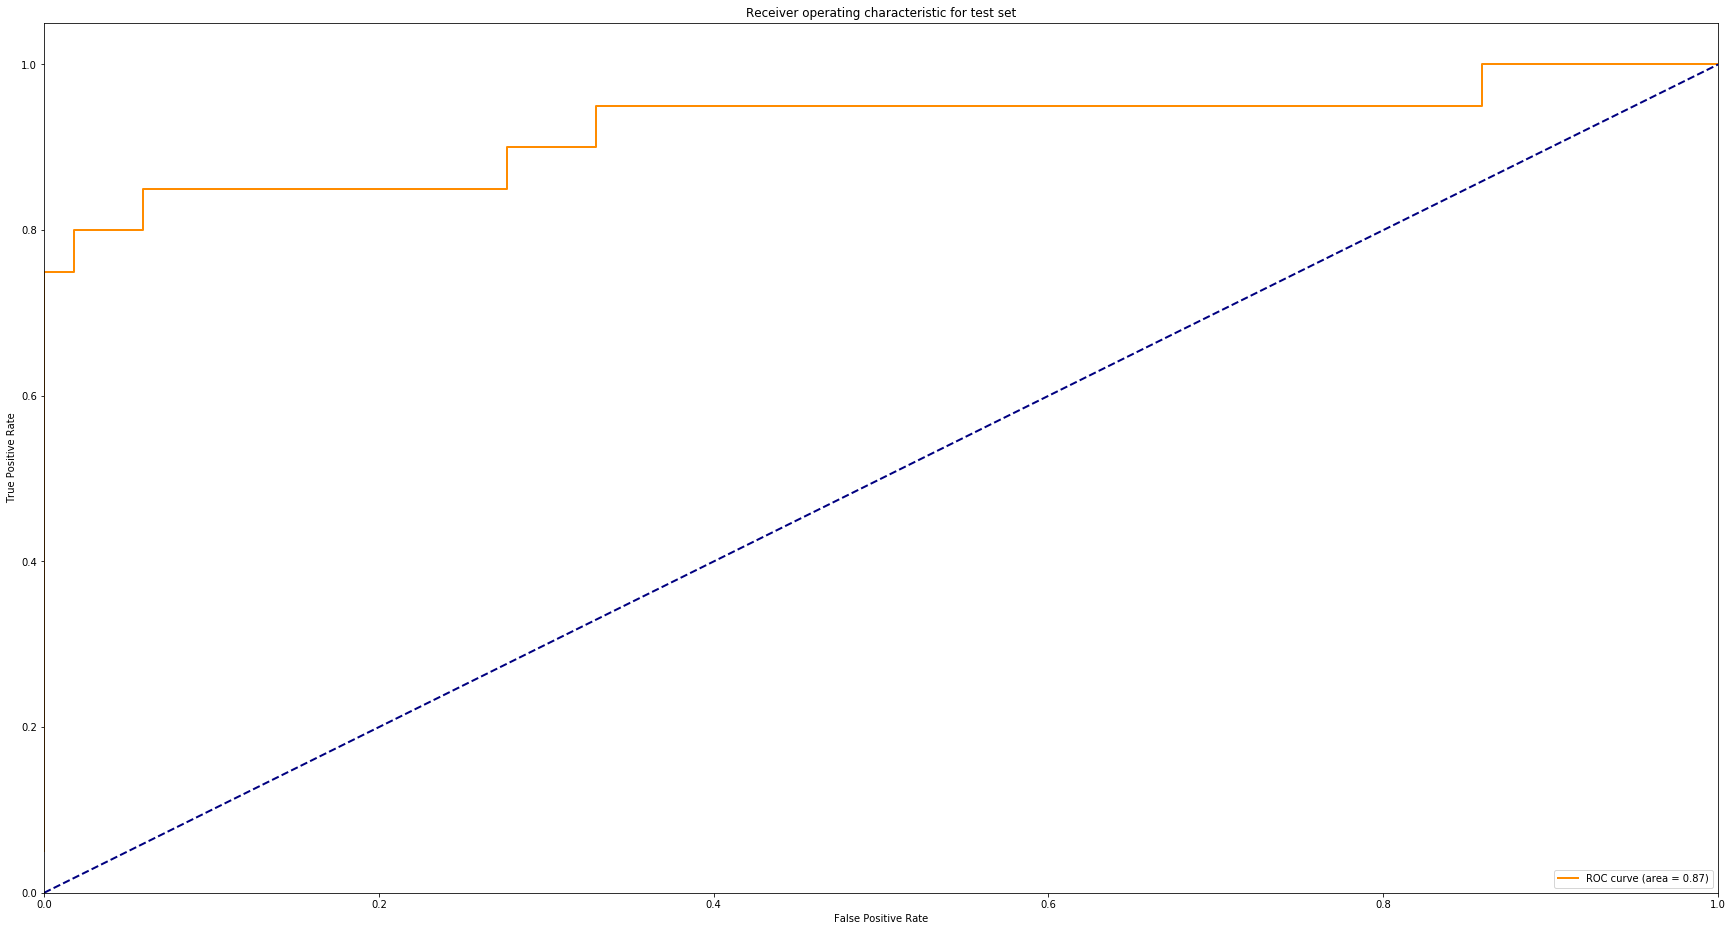

In [27]:
test_fpr, test_tpr, test_thresholds = roc_graph(y_test_prob, y_test)
test_roc_auc = test_metrics['AUC']

plt.figure()
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for test set')
plt.legend(loc="lower right")
plt.show()

Accuracy: 94.73684210526316%
Non-normalized conf_matrix:
[[164.   4.]
 [  6.  16.]]


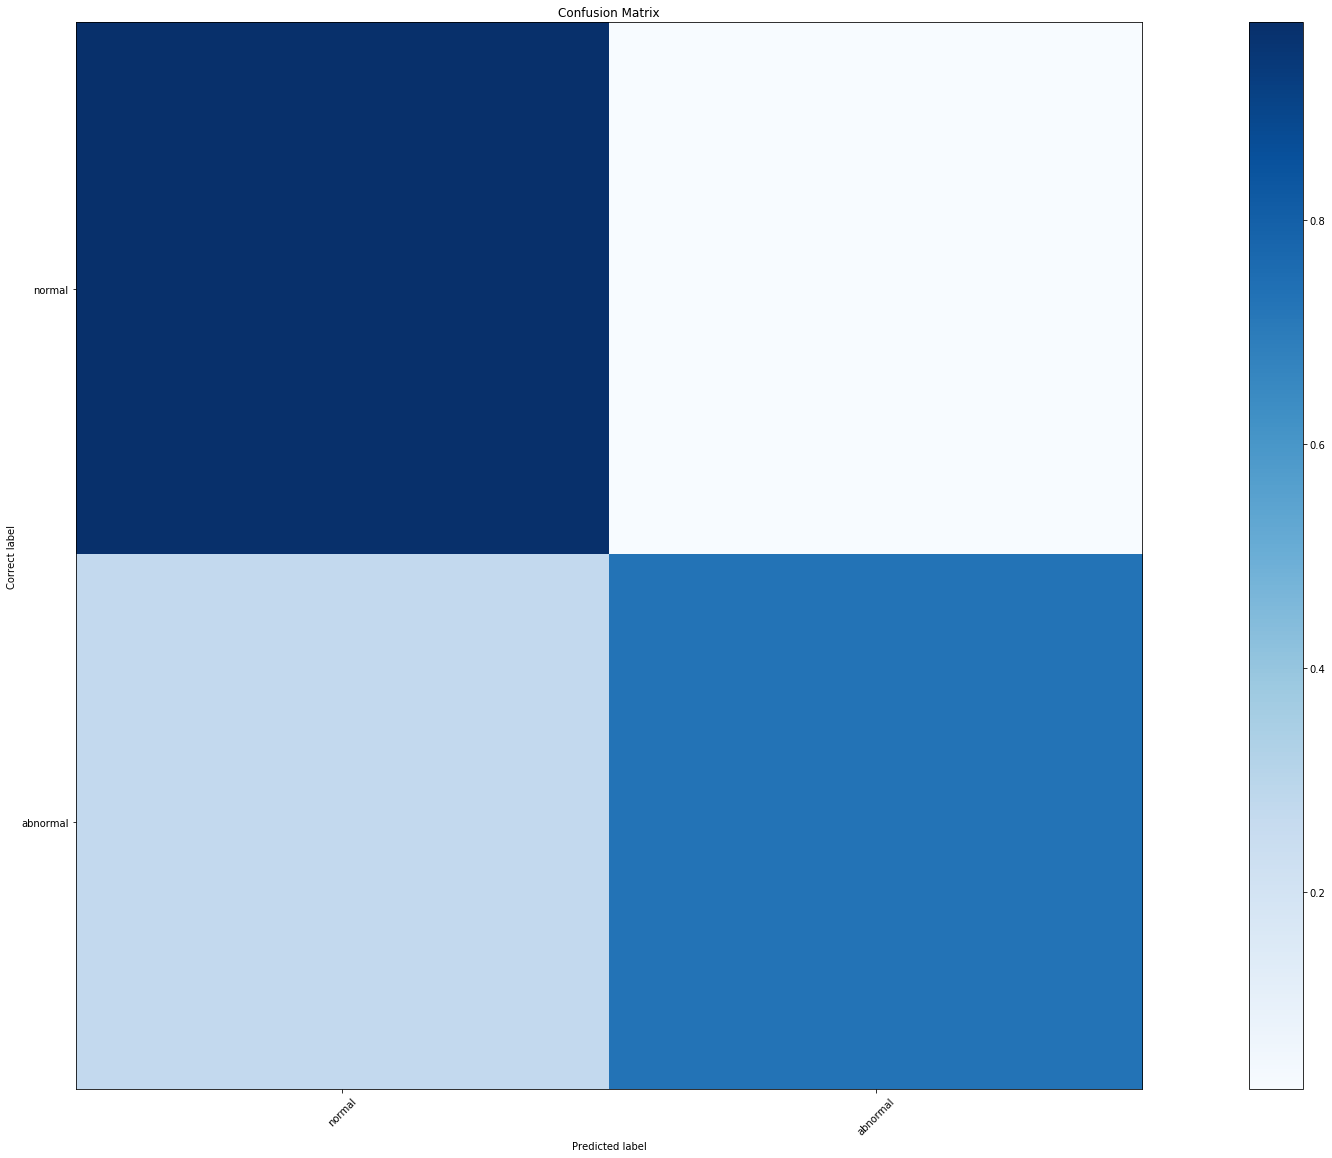

In [25]:
def confusion_matrix(results, categories, normalizeMatrix = True, plotConfusion=False):
    """ Generate confusion matrix
    - results = list of tuples of (correct label, predicted label)
    - categories = list of category names
    Returns confusion matrix; rows are correct labels and columns are predictions
    """
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    print("Non-normalized conf_matrix:")
    print(matrix)
    
    # Normalize confusion matrix
    if normalizeMatrix:
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy",matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

    
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots

classes = ['normal', 'abnormal']
confusion_matrix(list(zip(y_test_pred, y_test)), classes, plotConfusion=True)

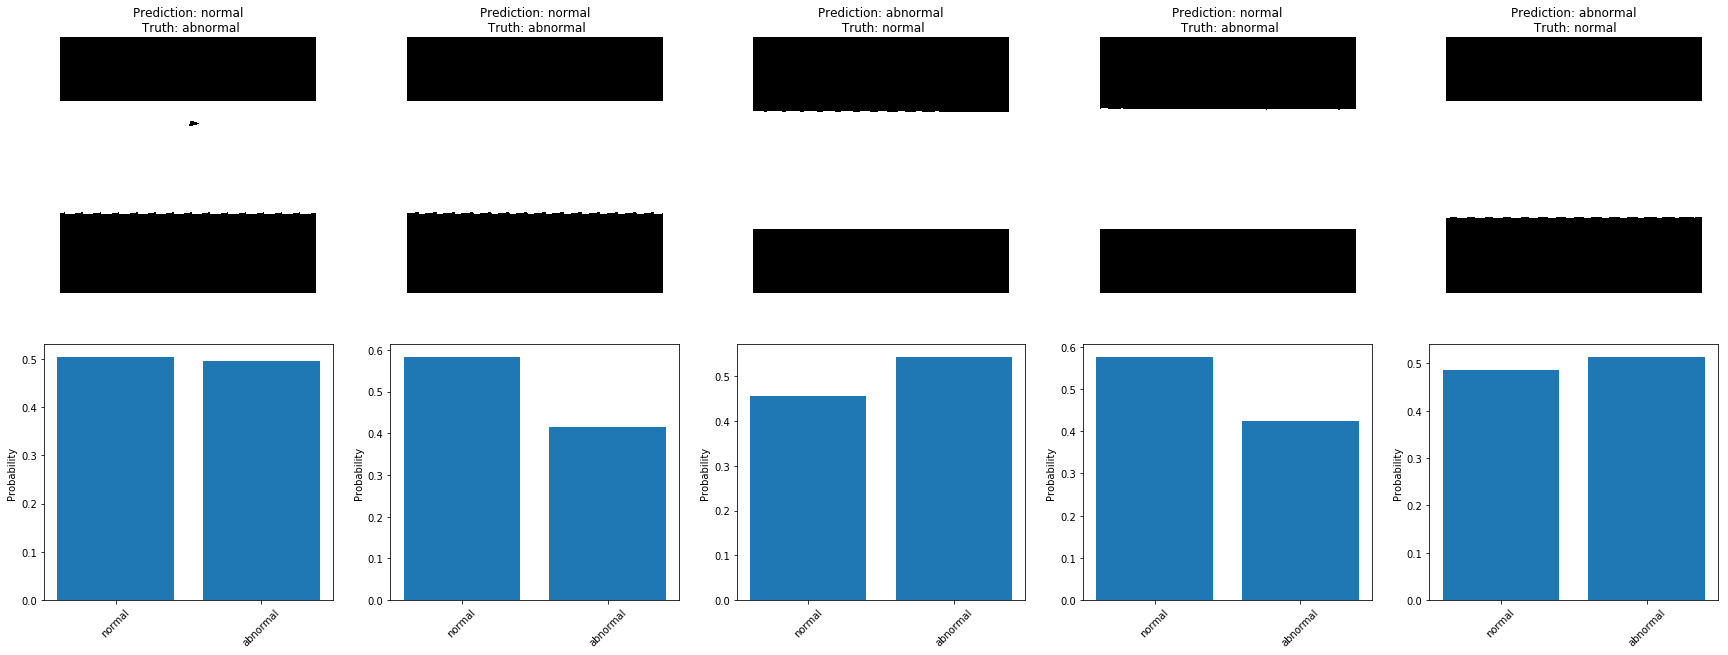

In [24]:
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots

# Visualize misclassified examples from the validation dataset.
num_classes = len(classes)
max_examples = 5

incorrect_idx = [idx for idx, incorrect in enumerate(np.array(y_test) != np.array(y_test_pred)) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(3):
        plt_idx = i * num_incorrect + y + 1
        if i == 0:
            plt.subplot(3, num_incorrect, plt_idx)
            plt.imshow(np.squeeze(X_test[idx]).astype('uint8'))
            plt.axis('off')
            plt.title("Prediction: %s\n Truth: %s" % (classes[y_test_pred[idx]], classes[y_test[idx]]))
        elif i == 1:
            plt.subplot(3, num_incorrect, plt_idx)
            log_probabilities = y_test_prob[idx]
            probabilities = np.exp(log_probabilities)
            y_pos = np.arange(len(classes))
            plt.bar(y_pos, probabilities)
            plt.xticks(y_pos, classes, rotation=45)
            plt.ylabel("Probability")
plt.show()

In [13]:
# num_classes = len(classes)
# img_size = (16, 8)
# num_channels = 1

# # Visualize the learned weights for each class.
# # Depending on your choice of learning rate and regularization strength, these may
# # or may not be nice to look at.
# w = model.conv3.weight.data.numpy() # convert to numpy arrays
# print(w.shape)
# w = w.reshape(num_classes, img_size[1], img_size[0], num_channels)
# w_min, w_max = np.min(w), np.max(w)
# for i in range(num_classes):
#     plt.subplot(2, 5, i + 1)
      
#     # Rescale the weights to be between 0 and 255
#     wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
#     plt.imshow(wimg.astype('uint8'))
#     plt.axis('off')
#     plt.title(classes[i])